In [1]:
# ==========================================
# 1. ENVIRONMENT SETUP & LIBRARIES
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tqdm import tqdm # Progress bar

# Constants
IMG_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 30 # Increased for Early Stopping to work
dataset_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# ==========================================
# 2. THE CORE SCIENCE: FREQUENCY DOMAIN TRANSFORM
# ==========================================
def apply_fft(image):
    """
    Converts a spatial image (pixels) into a Frequency Spectrum (signals).
    This reveals the 'invisible' grid artifacts left by AI generators.
    """
    # 1. Convert to grayscale (Frequency analysis is usually done on intensity)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2. Apply FFT (Fast Fourier Transform)
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    # 3. Shift zero frequency to the center
    dft_shift = np.fft.fftshift(dft)
    
    # 4. Calculate Magnitude Spectrum
    # We add 1 to avoid log(0) errors
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]) + 1)
    
    # 5. Normalize to 0-1 range for the Neural Network
    magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 1, cv2.NORM_MINMAX)
    
    # 6. Expand dims to make it (32, 32, 1) -> Compatible with CNN input
    return np.expand_dims(magnitude_spectrum, axis=-1)

print("✅ Frequency Analysis Function Defined.")

2026-02-07 13:36:55.554875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770471415.763326      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770471415.830430      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770471416.349457      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471416.349501      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471416.349503      24 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
✅ Frequency Analysis Function Defined.


In [2]:
# ==========================================
# 3. DATA LOADING & PREPROCESSING
# ==========================================
def load_and_process_data(split_name):
    """
    Loads images, applies FFT, and creates labels.
    split_name: 'train' or 'test'
    """
    base_path = os.path.join(dataset_dir, split_name)
    classes = ['REAL', 'FAKE'] # 0 = Real, 1 = Fake
    
    X_spatial = []   # Original Images (optional, for visualization)
    X_freq = []      # Frequency Spectrums (for training)
    y = []           # Labels
    
    print(f"Processing {split_name} data...")
    
    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        files = os.listdir(class_path)
        
        # tqdm shows a progress bar
        for file in tqdm(files, desc=f"Loading {class_name}"):
            img_path = os.path.join(class_path, file)
            try:
                # Read Image
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Fix CV2 color format
                
                # Apply FFT
                freq_img = apply_fft(img)
                
                # Append
                X_freq.append(freq_img)
                y.append(label_idx)
                
                # Only save spatial images for test set to save RAM
                if split_name == 'test':
                    X_spatial.append(img)
                    
            except Exception as e:
                pass

    return np.array(X_spatial), np.array(X_freq), np.array(y)

# Load the data
# Note: This might take 2-4 minutes
X_train_spatial_dummy, X_train_freq, y_train = load_and_process_data('train') # We ignore spatial for train to save RAM
X_test_spatial, X_test_freq, y_test = load_and_process_data('test')

print(f"Training Data Shape: {X_train_freq.shape}")
print(f"Test Data Shape: {X_test_freq.shape}")

Processing train data...


Loading FAKE: 100%|██████████| 50000/50000 [04:38<00:00, 179.45it/s]


Processing test data...


Loading FAKE: 100%|██████████| 10000/10000 [00:57<00:00, 172.94it/s]

Training Data Shape: (100000, 32, 32, 1)
Test Data Shape: (20000, 32, 32, 1)


Visualizing Data samples...


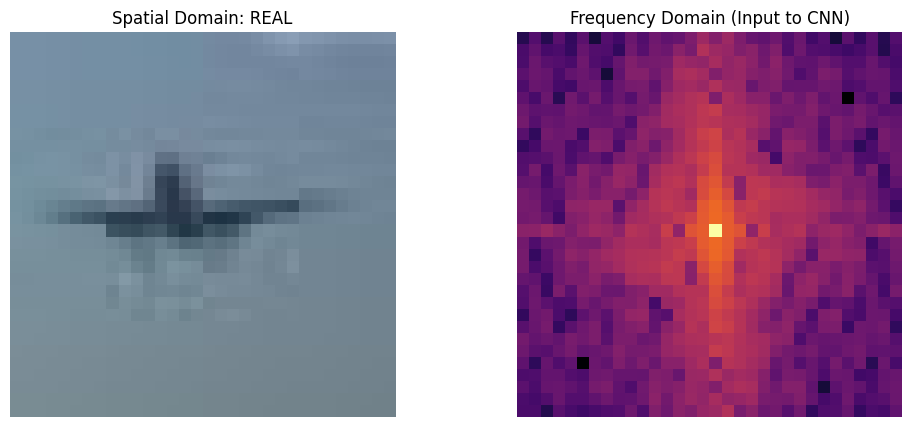

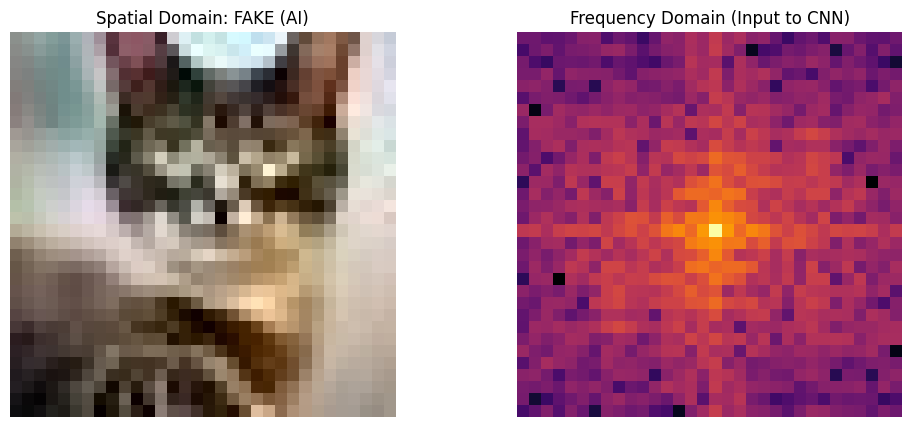

In [3]:
# ==========================================
# 4. VISUALIZATION: SPATIAL VS FREQUENCY
# ==========================================
def plot_comparison(index, dataset_x, dataset_freq, dataset_y):
    plt.figure(figsize=(12, 5))
    
    # Original Image (Spatial)
    plt.subplot(1, 2, 1)
    if len(dataset_x) > 0:
        plt.imshow(dataset_x[index])
    else:
        plt.text(0.5, 0.5, "Spatial Data Not Loaded to RAM", ha='center')
    
    label = "FAKE (AI)" if dataset_y[index] == 1 else "REAL"
    plt.title(f"Spatial Domain: {label}")
    plt.axis('off')
    
    # Frequency Spectrum
    plt.subplot(1, 2, 2)
    plt.imshow(dataset_freq[index].squeeze(), cmap='inferno') 
    plt.title(f"Frequency Domain (Input to CNN)")
    plt.axis('off')
    
    plt.show()

# Show a Real Image vs Fake Image from the Test Set
print("Visualizing Data samples...")
try:
    # We use the test set because we saved the spatial images there
    plot_comparison(0, X_test_spatial, X_test_freq, y_test) # Likely Real
    plot_comparison(-1, X_test_spatial, X_test_freq, y_test) # Likely Fake
except Exception as e:
    print(f"Skipping visualization: {e}")

In [4]:
# ==========================================
# 5. MODEL ARCHITECTURE
# ==========================================
def build_freq_detector():
    model = models.Sequential([
        # Input: (32, 32, 1) -> The Frequency Spectrum
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Dense Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), # Prevent overfitting
        layers.Dense(1, activation='sigmoid') # Binary Classification
    ])
    
    # UPGRADE 1: SLOWER LEARNING RATE
    # 0.0001 is safer than default 0.001
    opt = optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_freq_detector()
model.summary()

I0000 00:00:1770472110.661776      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770472110.667948      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,369 (2.36 MB)

 Trainable params: 617,921 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# ==========================================
# 6. TRAINING WITH EARLY STOPPING
# ==========================================

# UPGRADE 2: EARLY STOPPING
# Stop if validation loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Starting Training...")
history = model.fit(
    X_train_freq, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # 20% of training data used for validation
    callbacks=[early_stopping],
    verbose=1
)

# UPGRADE 3: SAVE THE MODEL
model.save('frequency_detector_v2.keras')
print("✅ Model saved successfully as 'frequency_detector_v2.keras'")

Starting Training...
Epoch 1/30


I0000 00:00:1770472115.584905      68 service.cc:152] XLA service 0x7f055c006370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770472115.584938      68 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770472115.584942      68 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770472116.138615      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


  28/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5734 - loss: 0.8318

I0000 00:00:1770472119.943753      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7456 - loss: 0.5258 - val_accuracy: 0.5763 - val_loss: 0.7889
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8117 - loss: 0.4178 - val_accuracy: 0.6840 - val_loss: 0.6704
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8284 - loss: 0.3840 - val_accuracy: 0.7206 - val_loss: 0.5969
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8385 - loss: 0.3660 - val_accuracy: 0.7542 - val_loss: 0.5378
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8475 - loss: 0.3507 - val_accuracy: 0.5984 - val_loss: 0.8757
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8540 - loss: 0.3335 - val_accuracy: 0.7528 - val_loss: 0.5639
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8640 - loss: 0.3148 - val_accuracy: 0.8252 - val_loss: 0.4175
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8709 - loss: 0.3030 - val_accura

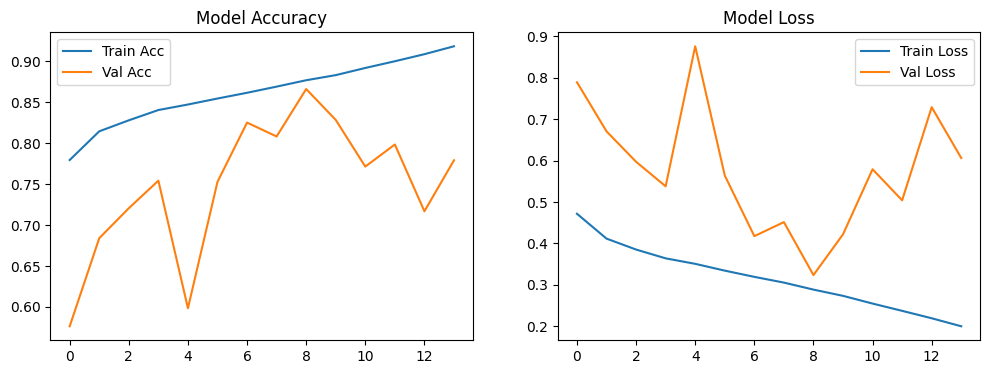

Generating Confusion Matrix...
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


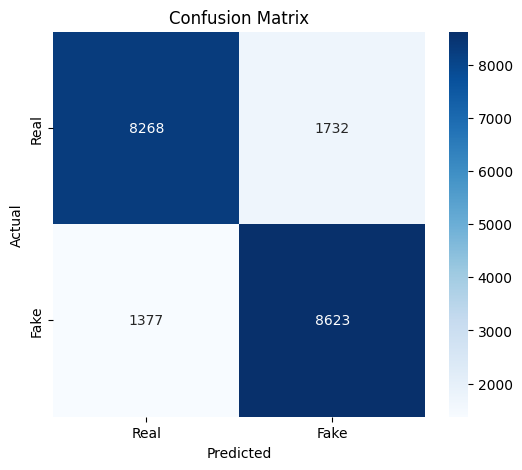


Classification Report:

              precision    recall  f1-score   support

        Real       0.86      0.83      0.84     10000
        Fake       0.83      0.86      0.85     10000

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



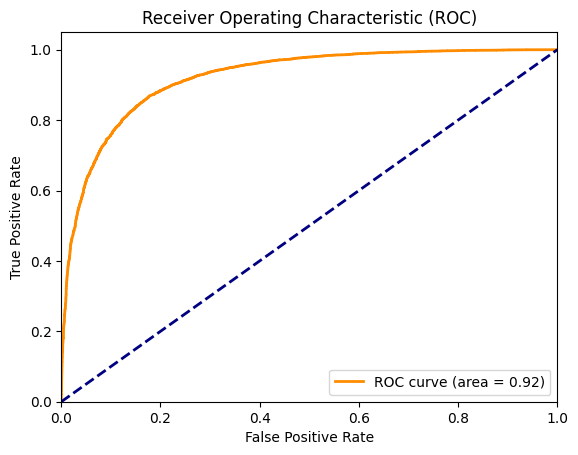

In [6]:
# ==========================================
# 7. PERFORMANCE EVALUATION
# ==========================================

# A. Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# B. Confusion Matrix
print("Generating Confusion Matrix...")
y_pred_prob = model.predict(X_test_freq)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# C. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# D. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [7]:
# ==========================================
# 8. REAL-WORLD TESTING (INFERENCE)
# ==========================================
def predict_custom_image(image_path):
    try:
        # 1. Read Image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return
        
        # 2. Resize to 32x32 (Model Expectation)
        img_resized = cv2.resize(img, (32, 32))
        
        # 3. Frequency Transform
        freq_input = apply_fft(img_resized)
        freq_input = np.expand_dims(freq_input, axis=0) # Shape: (1, 32, 32, 1)
        
        # 4. Predict
        prediction = model.predict(freq_input)
        confidence = prediction[0][0]
        
        # 5. Logic
        # 0 = Real, 1 = Fake (Based on CIFAKE folder structure)
        if confidence > 0.5:
            label = "FAKE (AI Generated)"
            conf_val = confidence
            color = 'red'
        else:
            label = "REAL (Human)"
            conf_val = 1 - confidence
            color = 'green'
            
        # 6. Show Result
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {label}\nConfidence: {conf_val*100:.2f}%", color=color, fontweight='bold')
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing image: {e}")

# Instructions
print("✅ Prediction System Ready.")
print("To test an image, upload it to Kaggle and run:")
print("predict_custom_image('path_to_your_image.jpg')")

✅ Prediction System Ready.
To test an image, upload it to Kaggle and run:
predict_custom_image('path_to_your_image.jpg')
